In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [5]:
# Загрузка датасета
df = pd.read_csv("S02-hw-dataset.csv")

In [6]:
# первые строки
df.head()

,user_id,age,country,purchases,revenue
0,1,25.0,FR,7,749
1,2,24.0,RU,5,1115
2,3,52.0,FR,7,399
3,4,31.0,RU,6,654
4,5,NaN,DE,6,1296


In [7]:
# информация о столбцах и типах
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41 entries, 0 to 40
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   user_id    41 non-null     int64  
 1   age        39 non-null     float64
 2   country    41 non-null     object 
 3   purchases  41 non-null     int64  
 4   revenue    41 non-null     int64  
dtypes: float64(1), int64(3), object(1)
memory usage: 1.7+ KB


In [8]:
# базовые описательные статистики по числовым признакам
df.describe()

,user_id,age,purchases,revenue
count,41.000000,39.000000,41.000000,41.000000
mean,20.243902,36.512821,4.829268,820.048780
std,11.659289,18.304259,2.710189,613.127269
min,1.000000,5.000000,-1.000000,0.000000
25%,10.000000,24.000000,3.000000,432.000000
50%,20.000000,33.000000,5.000000,693.000000
75%,30.000000,45.500000,7.000000,1115.000000
max,40.000000,120.000000,11.000000,2475.000000


В датасете 41 наблюдение и 5 столбцов: user_id, age, country, purchases, revenue.
Столбец age содержит пропуски, тип данных – float64. Остальные числовые признаки (user_id, purchases, revenue) – целые, country – категориальный (object).

In [9]:
missing_share = df.isna().mean()
missing_share

user_id      0.00000
age          0.04878
country      0.00000
purchases    0.00000
revenue      0.00000
dtype: float64

Пропуски есть только в столбце age (~5% строк). В остальных столбцах пропусков нет.

In [12]:
# полностью дублирующие строки
duplicates_mask = df.duplicated()
df[duplicates_mask]

,user_id,age,country,purchases,revenue
40,10,24.0,RU,7,511


In [14]:
df['user_id'].value_counts().head()

user_id
10    2
1     1
3     1
2     1
5     1
Name: count, dtype: int64

Найдена одна полностью дублирующаяся строка (одинаковые значения по всем столбцам).
Также видно, что user_id обычно уникален, но есть пользователь, встречающийся дважды – это потенциальный дубль и требует внимания.

In [15]:
# отрицательные значения покупок
neg_purchases = df[df["purchases"] < 0]
neg_purchases

,user_id,age,country,purchases,revenue
5,6,120.0,FR,-1,785


In [16]:
# очень маленький или очень большой возраст
strange_age = df[(df["age"] < 10) | (df["age"] > 100)]
strange_age

,user_id,age,country,purchases,revenue
5,6,120.0,FR,-1,785
20,21,5.0,RU,8,1488


In [18]:
# нулевой revenue при ненулевых покупках
zero_rev_nonzero_pur = df[(df["revenue"] == 0) & (df["purchases"] > 0)]
zero_rev_nonzero_pur

,user_id,age,country,purchases,revenue
10,11,24.0,US,4,0


обнаружен пользователь с отрицательным числом покупок (purchases < 0), что физически невозможно – это явная ошибка данных;

есть наблюдения с возрастом 5 и 120 лет, что выглядит подозрительно и, скорее всего, является либо ошибкой ввода, либо тестовыми данными;

встречается случай с нулевой выручкой при ненулевом числе покупок, что говорит о неконсистентности данных между транзакциями и отчётами по выручке.

In [21]:
# частоты стран
country_counts = df["country"].value_counts()
country_counts

country
RU    13
FR    12
US     8
DE     6
CN     2
Name: count, dtype: int64

In [20]:
country_freq = df["country"].value_counts(normalize=True)
country_freq

country
RU    0.317073
FR    0.292683
US    0.195122
DE    0.146341
CN    0.048780
Name: proportion, dtype: float64

Наибольшее число пользователей в выборке приходится на страну RU, далее по убыванию идут FR, US, DE, CN.

In [22]:
grouped_country = (
    df
    .groupby("country")
    .agg(
        users_count=("user_id", "nunique"),
        mean_age=("age", "mean"),
        mean_purchases=("purchases", "mean"),
        mean_revenue=("revenue", "mean"),
        total_revenue=("revenue", "sum"),
    )
    .sort_values("total_revenue", ascending=False)
)
grouped_country


,users_count,mean_age,mean_purchases,mean_revenue,total_revenue
country,,,,,
RU,12,30.076923,4.769231,790.076923,10271
DE,6,34.600000,6.500000,1445.500000,8673
FR,12,46.250000,4.250000,675.916667,8111
US,8,36.714286,4.625000,557.375000,4459
CN,2,24.000000,4.500000,1054.000000,2108


По странам видно, что суммарная выручка и среднее число покупок различаются: некоторые страны, например DE, при меньшем числе пользователей дают более высокую среднюю выручку.

In [26]:
age_bins = [0, 18, 30, 45, 60, 150]
age_labels = ["0-18", "19-30", "31-45", "46-60", "60+"]

df["age_group"] = pd.cut(df["age"], bins=age_bins, labels=age_labels, right=True)

age_group_stats = (
    df
    .groupby("age_group", observed=True)
    .agg(
        users_count=("user_id", "nunique"),
        mean_purchases=("purchases", "mean"),
        mean_revenue=("revenue", "mean"),
    )
)
age_group_stats


,users_count,mean_purchases,mean_revenue
age_group,,,
0-18,2,6.000000,1296.000000
19-30,12,4.461538,565.538462
31-45,14,5.357143,1108.214286
46-60,9,4.333333,605.777778
60+,1,-1.000000,785.000000


Основная часть пользователей — в возрастных группах 19–30 и 31–45 лет, при этом самые «выгодные» по средней выручке и числу покупок — группы 0–18 и 31–45.
В группе 60+ всего один пользователь с числом покупок −1, что, скорее всего, является некорректным значением и примером проблемы качества данных.

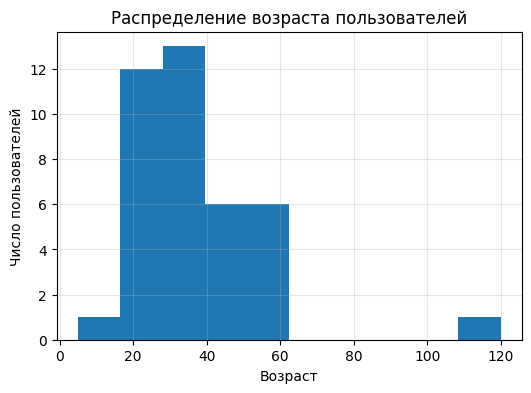

In [28]:
plt.figure(figsize=(6, 4))
plt.hist(df["age"].dropna(), bins=10)  # убираем NaN
plt.xlabel("Возраст")
plt.ylabel("Число пользователей")
plt.title("Распределение возраста пользователей")
plt.grid(True, alpha=0.3)

plt.savefig("figures/age_hist.png", dpi=300, bbox_inches="tight")
plt.show()

Большинство пользователей находятся в диапазоне примерно от 20 до 60 лет.
Есть единичное значение около 120 лет, которое выглядит как выброс и возможно ошибка в данных.

<Figure size 600x400 with 0 Axes>

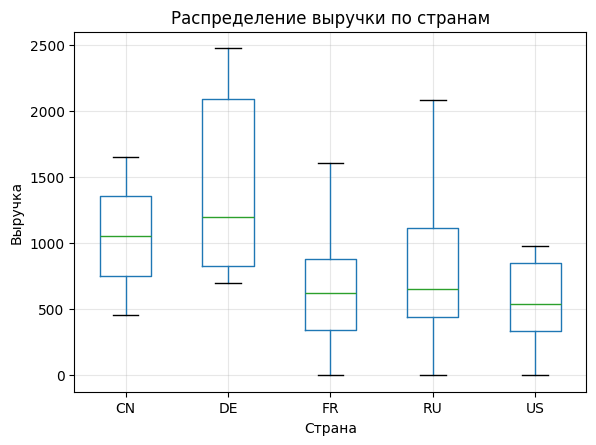

<Figure size 640x480 with 0 Axes>

In [30]:
plt.figure(figsize=(6, 4))
df.boxplot(column="revenue", by="country")
plt.xlabel("Страна")
plt.ylabel("Выручка")
plt.title("Распределение выручки по странам")
plt.suptitle("")  # убираем лишний заголовок 
plt.grid(True, alpha=0.3)
plt.show()

plt.savefig("figures/revenue_boxplot_by_country.png", dpi=300, bbox_inches="tight")
plt.show()

Выручка заметно различается между странами: медиана и разброс выше всего у DE и CN.
У FR, RU и US медианные значения ниже, но в RU и DE есть пользователи с очень высокой выручкой.

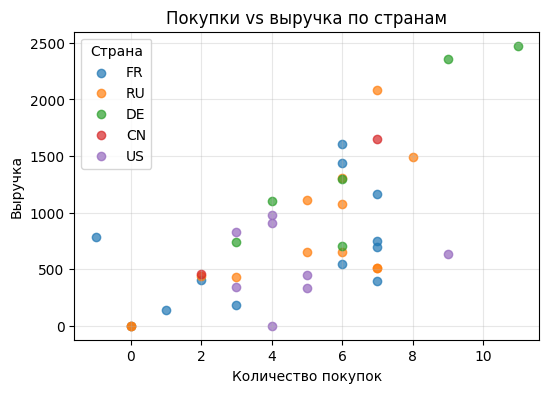

<Figure size 640x480 with 0 Axes>

In [35]:
plt.figure(figsize=(6, 4))

for country in df["country"].unique():
    subset = df[df["country"] == country]
    plt.scatter(
        subset["purchases"],
        subset["revenue"],
        label=country,
        alpha=0.7,
    )

plt.xlabel("Количество покупок")
plt.ylabel("Выручка")
plt.title("Покупки vs выручка по странам")
plt.legend(title="Страна")
plt.grid(True, alpha=0.3)
plt.show()

plt.savefig("figures/purchases_vs_revenue_by_country.png", dpi=300, bbox_inches="tight")
plt.show()

В целом видно положительную связь: чем больше покупок, тем выше выручка.
Точки разных стран показывают, что при одинаковом числе покупок выручка может отличаться — чек пользователя зависит от страны.